In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l1_l2


In [63]:
data = pd.read_csv("C:\\Users\\krist\\Downloads\\NUS Fintech Society\\Project\\NUS-FinTech-Society-Project\\project.ipynb\\dogecoin.csv")
data.isnull().sum()
# there is a missing value in the close column 


Date     0
Close    1
dtype: int64

In [64]:
# Data processing 
# Fill the missing close value using the previous dates' value
data = data.ffill()
# convert date column into data time type 
data['Date'] = pd.to_datetime(data["Date"])
# Sort the DataFrame by the 'Date' column in ascending order
data = data.sort_values(by='Date', ascending=True)



In [65]:
data.isnull().sum()
# No more missing values 

Date     0
Close    0
dtype: int64

In [66]:
# Create Target column ( Only start to have values from Day 8 onwards )
data['Target'] = np.nan
data.loc[7:, 'Target'] = (data['Close'].diff() > 0).astype(int)
data["Target"] = data["Target"].astype('category')


In [67]:
def create_features(data, target):
    """
    Parameters:
    - data: A pandas Series containing the feature data (e.g.,
    Closing prices).
    - target: A pandas Series containing the target variable
    (e.g., the column indicating up or down).
    Returns:
    - A tuple containing two numpy arrays: features with
    matching shapes for LSTM (X): (None, 7, 1) and target (y).
    """
    X, y = [], []
    for i in range(len(data) - 7):
        X.append(data[i:i + 7].values)
        y.append(target[i + 7])
    X = np.array(X)
    return X.reshape((X.shape[0], X.shape[1], 1)), np.array(y)

In [68]:
# Create x and y ( to prepare for model training )
data_x = data["Close"]
target = data["Target"]
X,y = create_features(data_x,target)
# In y: 0 represents that the price on a given day is lower than the previous day 
# 1 represents that the price on a given day is higher than the previous day 



In [69]:
# Model training 

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Standardise the X_train and X_val separately
scaler = StandardScaler()
X_train_reshaped = X_train.reshape(-1, 1)
X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(X_train.shape)
X_val_reshaped = X_val.reshape(-1, 1)
X_val_scaled = scaler.transform(X_val_reshaped).reshape(X_val.shape)


In [70]:

def objective(trial):
    # Define hyperparameters to tune
    n_units = trial.suggest_int('n_units', 32, 128)  # Units for the second LSTM layer (if added)    
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)  # Learning rate
    l1_rate = trial.suggest_float('l1_rate', 1e-6, 1e-2, log=True)  # L1 regularization strength
    l2_rate = trial.suggest_float('l2_rate', 1e-6, 1e-2, log=True)  # L2 regularization strength
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])  # Batch size
    epochs = trial.suggest_int('epochs', 20, 100)  # Number of epochs
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(n_units, input_shape=(7, 1), kernel_regularizer= l1_l2(l1 = l1_rate, l2 = l2_rate),return_sequences= False))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l1_l2(l1=l1_rate, l2=l2_rate)))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    # Early stopping to prevent overfitting during training 
    early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    # Train the model
    history = model.fit(
        X_train_scaled, y_train,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        validation_data=(X_val_scaled, y_val),
        callbacks = [early_stopping]
    )

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val, verbose=0)

    # Optuna will maximize this metric
    return val_accuracy



In [73]:
# Create a study
study = optuna.create_study(direction='maximize')  # We aim to maximize validation accuracy

# Run the optimization
study.optimize(objective, n_trials=50)  # Perform 50 trials



[I 2024-11-09 11:46:59,557] A new study created in memory with name: no-name-77846b3e-02ca-4000-8121-be5a5f84468a
c:\Users\krist\Downloads\NUS Fintech Society\Project\NUS-FinTech-Society-Project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2024-11-09 11:47:05,339] Trial 0 finished with value: 0.5275229215621948 and parameters: {'n_units': 67, 'learning_rate': 0.0006221149515966057, 'l1_rate': 1.3076247006566303e-05, 'l2_rate': 2.993570123701334e-05, 'batch_size': 64, 'epochs': 81}. Best is trial 0 with value: 0.5275229215621948.
[I 2024-11-09 11:47:12,736] Trial 1 finished with value: 0.4587155878543854 and parameters: {'n_units': 48, 'learning_rate': 0.00908419333038116, 'l1_rate': 0.001962364913907374, 'l2_rate': 0.0014537384715814599, 'batch_size': 32, 'epoch

In [81]:
# Best hyperparameters
print("Best hyperparameters:", study.best_params)

# Best validation accuracy
print("Best validation accuracy:", study.best_value)

Best hyperparameters: {'n_units': 91, 'learning_rate': 0.004492060632487522, 'l1_rate': 7.34458539230516e-06, 'l2_rate': 1.2525473595422318e-06, 'batch_size': 64, 'epochs': 37}
Best validation accuracy: 0.5458715558052063


In [82]:
# Get the best hyperparameters
best_params = study.best_params

# Build the final model using the best hyperparameters
n_units = best_params['n_units']
learning_rate = best_params['learning_rate']
l1_rate = best_params['l1_rate']
l2_rate = best_params['l2_rate']
batch_size = best_params['batch_size']
epochs = best_params['epochs']

In [ ]:
# Create the model
model = Sequential()
model.add(LSTM(n_units, input_shape=(7, 1), kernel_regularizer=l1_l2(l1=l1_rate, l2=l2_rate), return_sequences=False))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l1_l2(l1=l1_rate, l2=l2_rate)))

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Train the model with the best parameters
history = model.fit(
    X_train_scaled, y_train,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping]
)

Epoch 1/37
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5061 - loss: 0.6921 - val_accuracy: 0.4587 - val_loss: 0.6968
Epoch 2/37
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4880 - loss: 0.6936 - val_accuracy: 0.5275 - val_loss: 0.6918
Epoch 3/37
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5168 - loss: 0.6921 - val_accuracy: 0.5138 - val_loss: 0.6925
Epoch 4/37
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5116 - loss: 0.6933 - val_accuracy: 0.5229 - val_loss: 0.6915
Epoch 5/37
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4907 - loss: 0.6925 - val_accuracy: 0.5092 - val_loss: 0.6925
Epoch 6/37
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5228 - loss: 0.6915 - val_accuracy: 0.5138 - val_loss: 0.6923
Epoch 7/37
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5262 - loss: 0.6901 - val_accuracy: 0.5092 - val_loss: 0.6928
Epoch 8/37
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4962 - loss: 0.6981 - val_accuracy: 0.5046 - v

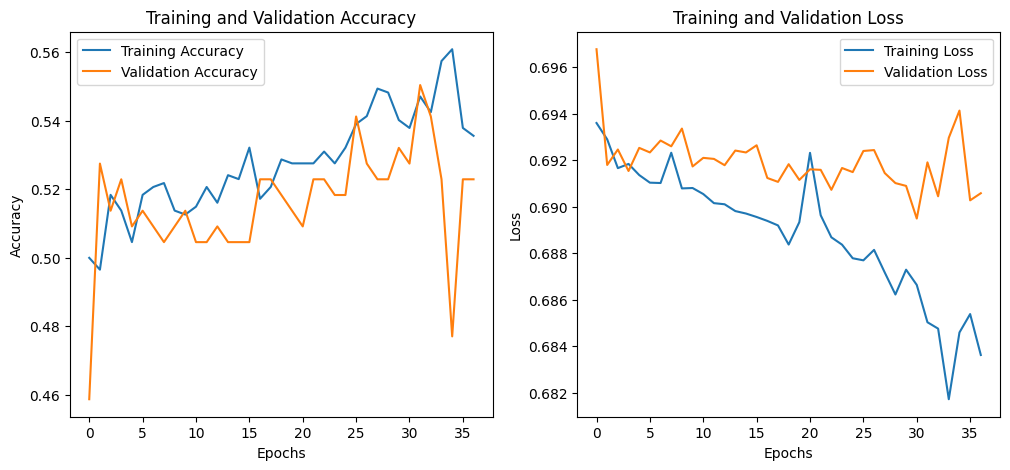

In [87]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()